Import Libraries

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

1) Explore the data.

In [14]:
data = pd.read_csv("ACME-HappinessSurvey2020.csv")
print(data.head(), "/n")
print(data.shape, "/n")
print(data.info(), "/n")
print(data.describe(), "/n")
print(data.isnull().sum(), "/n")
print(data.duplicated().sum(), "/n")
print(data.columns, "/n")
print(data.dtypes, "/n")
print(data.nunique(), "/n")
print(data.corr(), "/n")
print(data.skew(), "/n")
print(data.kurtosis(), "/n")
print(data.cov(), "/n")
print(data.dtypes)

   Y  X1  X2  X3  X4  X5  X6
0  0   3   3   3   4   2   4
1  0   3   2   3   5   4   3
2  1   5   3   3   3   3   5
3  0   5   4   3   3   3   5
4  0   5   4   3   3   3   5 /n
(126, 7) /n
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB
None /n
                Y          X1          X2          X3          X4          X5  \
count  126.000000  126.000000  126.000000  126.000000  126.000000  126.000000   
mean     0.547619    4.333333    2.531746    3.309524    3.746032    3.650794   
std      0.499714    0.800000    1.114892    1.023440    0.875776    1.147641   
min      0.000000    1

2) Visualize the data.

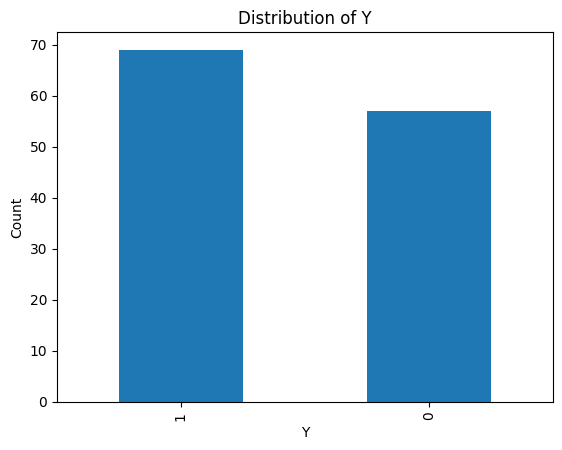

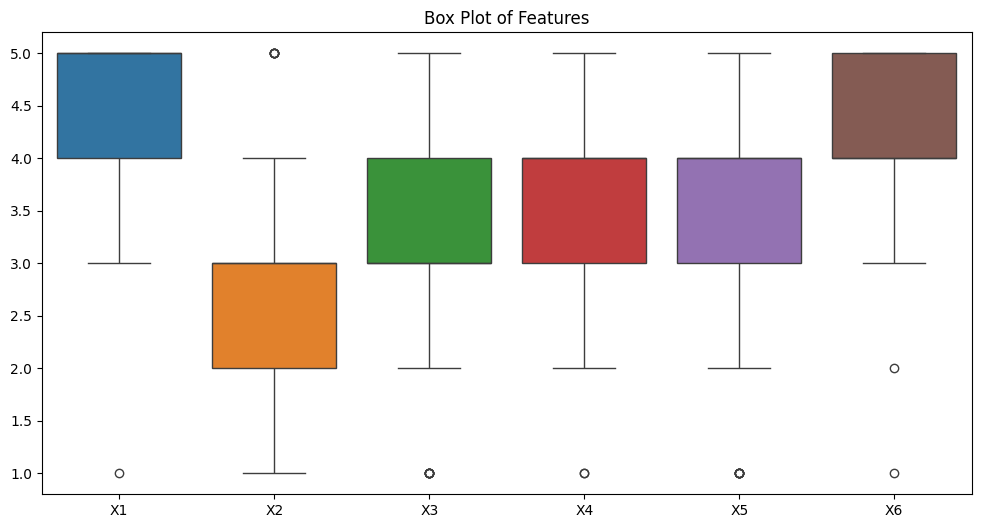

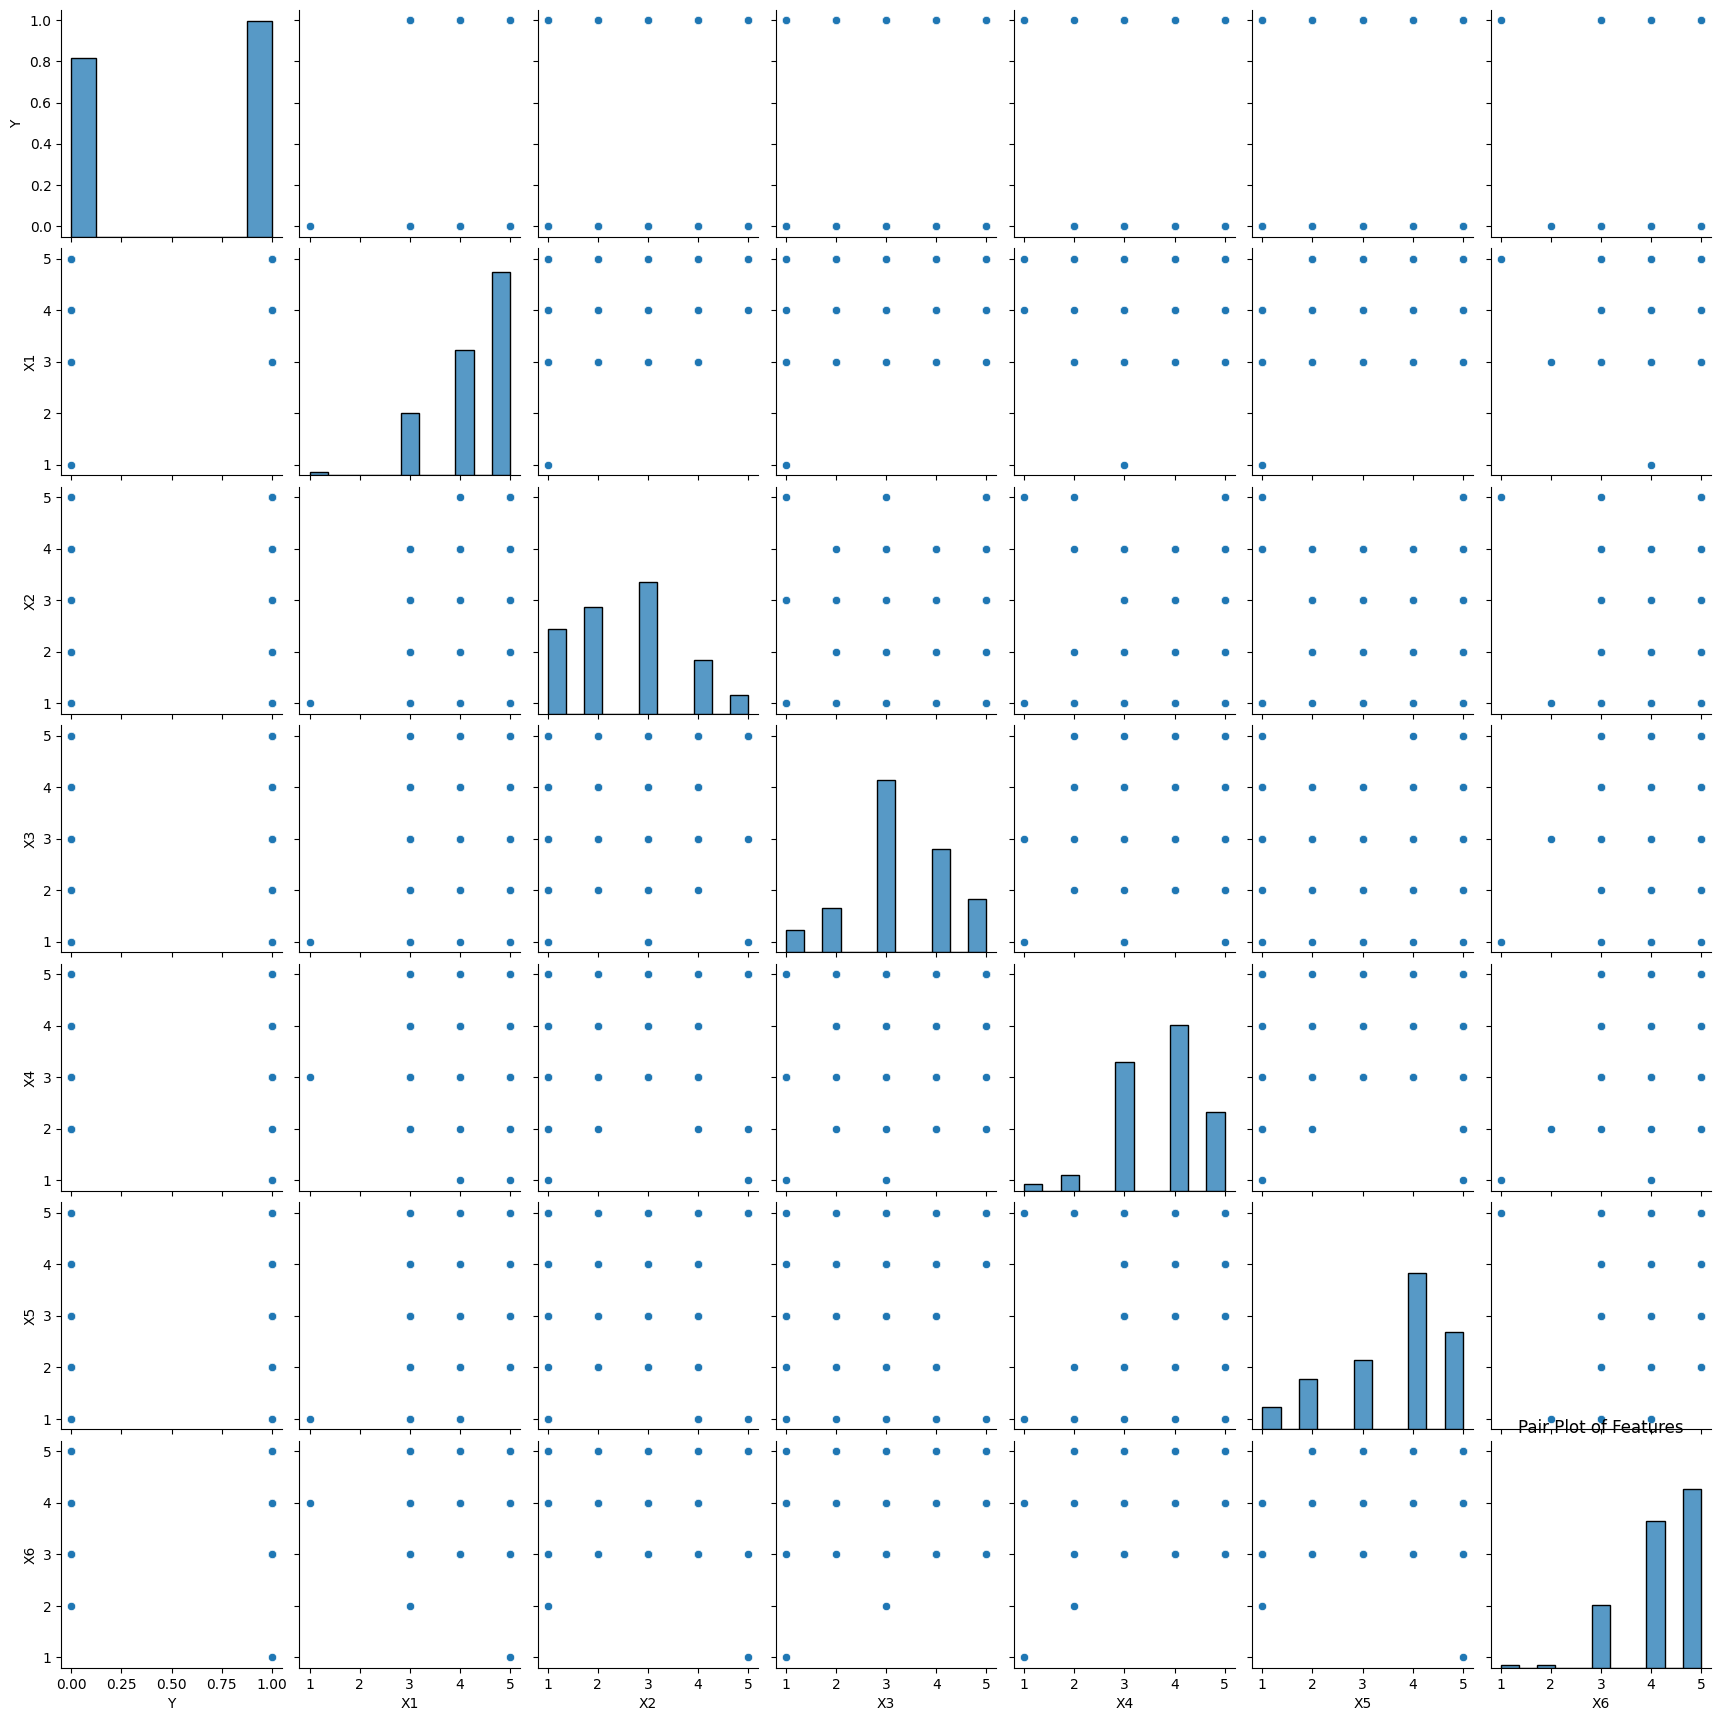

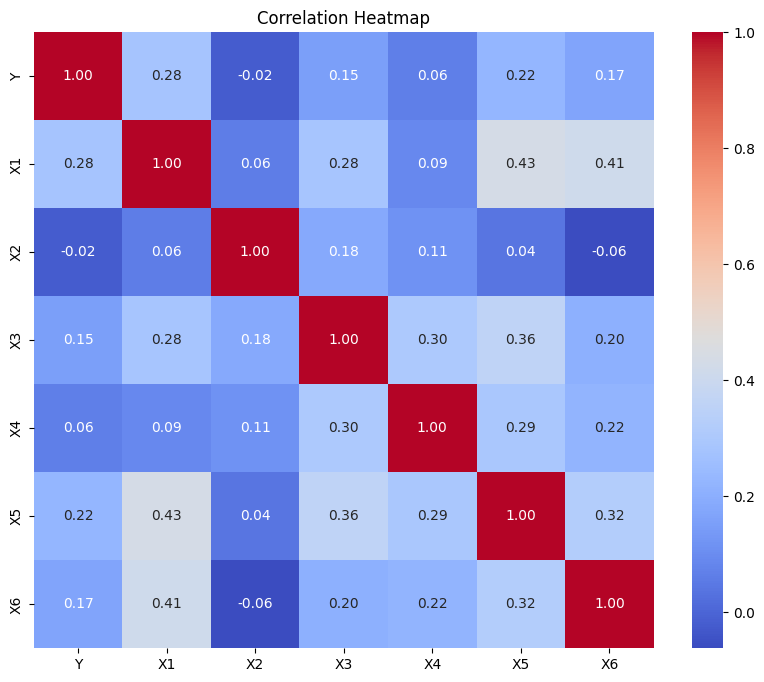

In [15]:
# Bar plot for the target variable
data['Y'].value_counts().plot(kind='bar')
plt.title('Distribution of Y')
plt.xlabel('Y')
plt.ylabel('Count')
plt.show()

# Box plot for features
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6']])
plt.title('Box Plot of Features')
plt.show()

# Pair plot to visualize relationships
sns.pairplot(data)
plt.title('Pair Plot of Features')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

3) Preprocess and split the data.

In [16]:
# Split data into features (X) and target (y)
X = data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6']]
y = data['Y']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE for class imbalance (Optional, can be removed if needed)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Feature Scaling (Standardize features)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

4) Define Random Forest model.

In [17]:
# Baseline Model - Random Forest
rf = RandomForestClassifier(random_state=42)

5) Hyperparameter tuning with GridSearchCV.

In [ ]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train_smote)

# Best Parameters from GridSearch
print("Best parameters from GridSearchCV:", grid_search.best_params_)

# Use the best model found by GridSearch
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters from GridSearchCV: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


6) Cross-validation for Baseline Model

In [19]:
# Perform cross-validation for the baseline model
cv_scores_baseline = cross_val_score(best_rf, X_train_scaled, y_train_smote, cv=5, scoring='accuracy')

print(f"Baseline Model Cross-Validation Accuracy: {cv_scores_baseline.mean() * 100:.2f}% ± {cv_scores_baseline.std() * 100:.2f}%")

Baseline Model Cross-Validation Accuracy: 67.27% ± 12.33%


7) Train and evaluate the model.

Baseline Model Accuracy: 76.92%

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.79      0.79      0.79        14

    accuracy                           0.77        26
   macro avg       0.77      0.77      0.77        26
weighted avg       0.77      0.77      0.77        26



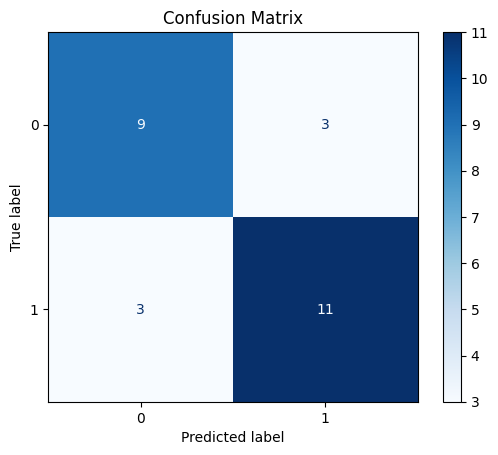

ROC-AUC Score: 0.81


In [20]:
# Predictions and evaluation
y_pred = best_rf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline Model Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

#  Display Confusion Matrix
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC-AUC Score (for binary classification)
roc_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test_scaled)[:, 1])
print(f"ROC-AUC Score: {roc_auc:.2f}")

8) Discover most important features.

C:\Users\d-kin\AppData\Local\Temp\ipykernel_29976\3268742231.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


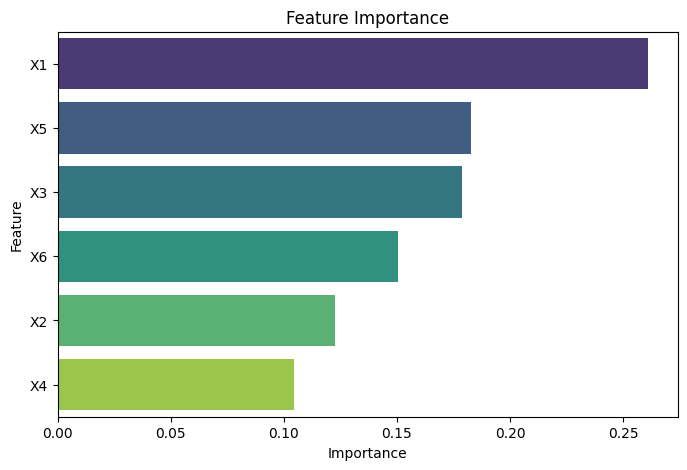

Optimal number of features: 6
Selected Features:  Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6'], dtype='object')


In [21]:
# Feature Importance Analysis
importances = best_rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot feature importance
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance')
plt.show()

# Recursive Feature Elimination with Cross-Validation (RFECV)
rfecv = RFECV(estimator=best_rf, step=1, cv=5, scoring='accuracy')
rfecv.fit(X_train_scaled, y_train_smote)

print("Optimal number of features: %d" % rfecv.n_features_)
print("Selected Features: ", X.columns[rfecv.support_])

9) Hyperparameter tuning and cross-validation for Optimised Model.

In [22]:
# Train with selected features from RFECV
X_train_selected = rfecv.transform(X_train_scaled)
X_test_selected = rfecv.transform(X_test_scaled)

# Hyperparameter tuning for Optimised Model
grid_search_optimized = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                                     param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search_optimized.fit(X_train_selected, y_train_smote)

# Best Parameters for Optimised Model
print("Best parameters from GridSearchCV (Optimised Model):", grid_search_optimized.best_params_)

# Use the best model found by GridSearch for Optimised Model
best_rf_optimized = grid_search_optimized.best_estimator_

# Perform cross-validation for the Optimised Model
cv_scores_optimized = cross_val_score(best_rf_optimized, X_train_selected, y_train_smote, cv=5, scoring='accuracy')
print(f"Optimised Model Cross-Validation Accuracy: {cv_scores_optimized.mean() * 100:.2f}% ± {cv_scores_optimized.std() * 100:.2f}%")

# Predictions and evaluation for Optimised Model
y_pred_optimized = best_rf_optimized.predict(X_test_selected)

optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
print(f"\nOptimised Model Accuracy with Selected Features: {optimized_accuracy * 100:.2f}%")
print("\nClassification Report (Optimised):\n", classification_report(y_test, y_pred_optimized))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters from GridSearchCV (Optimised Model): {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Optimised Model Cross-Validation Accuracy: 67.27% ± 12.33%

Optimised Model Accuracy with Selected Features: 76.92%

Classification Report (Optimised):
               precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.79      0.79      0.79        14

    accuracy                           0.77        26
   macro avg       0.77      0.77      0.77        26
weighted avg       0.77      0.77      0.77        26



10) Visualize the results.

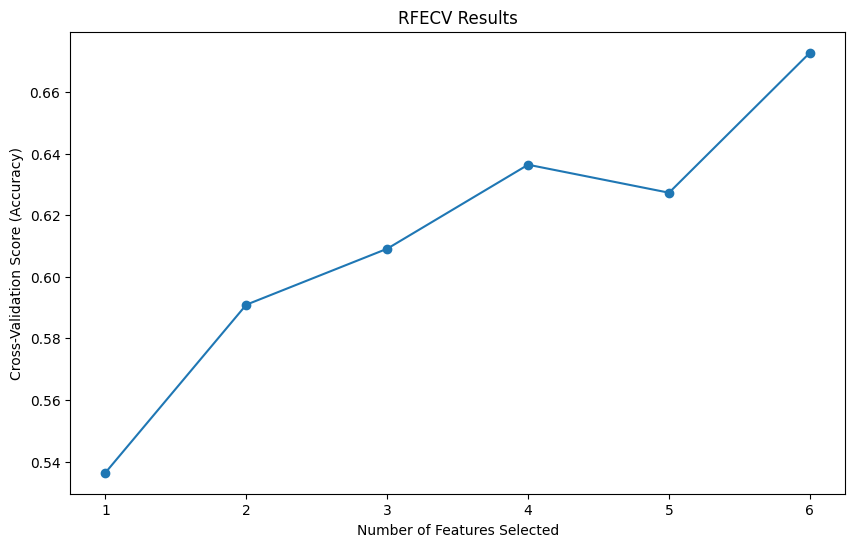

In [23]:
# Visualise RFECV results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], marker='o')
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validation Score (Accuracy)")
plt.title("RFECV Results")
plt.show()

11) Conslusion.

In [24]:
# Insights and Conclusions
print("Insights:")
print("- The X1 feature has been discovered to be the most impactful, followed by features X5 & X3 in second and X6 in third.")
print("- Reduced feature set improves model simplicity while maintaining performance.")

print(f"\nBaseline Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))

print(f"\nOptimised Model Accuracy with Selected Features: {optimized_accuracy * 100:.2f}%")
print("Classification Report (Optimised):\n", classification_report(y_test, y_pred_optimized))

Insights:
- The X1 feature has been discovered to be the most impactful, followed by features X5 & X3 in second and X6 in third.
- Reduced feature set improves model simplicity while maintaining performance.

Baseline Model Accuracy: 76.92%
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.79      0.79      0.79        14

    accuracy                           0.77        26
   macro avg       0.77      0.77      0.77        26
weighted avg       0.77      0.77      0.77        26


Optimised Model Accuracy with Selected Features: 76.92%
Classification Report (Optimised):
               precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.79      0.79      0.79        14

    accuracy                           0.77        26
   macro avg       0.77      0.77      0.77        26
weighted avg       0.77      0.77      0.77